# Compute Mean Square Error Between Average Noise with Real Locations and Perturbated Ones

In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import dotenv
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text
from itertools import product
import matplotlib.pyplot as plt

Connect to DB if there's not a saved CSV.

In [2]:
CSV_NAME = os.path.join('csvs', 'qos.csv')
df = None
if os.path.exists(CSV_NAME):
    df = pd.read_csv(CSV_NAME, index_col=0)
else:
    dotenv.load_dotenv('.env')
    engine = create_engine('postgresql://{0}:{1}@{2}/{3}'.format(
        os.environ.get("TYPEORM_USERNAME"),
        os.environ.get("TYPEORM_PASSWORD"),
        os.environ.get("TYPEORM_HOST"),
        os.environ.get("TYPEORM_DATABASE")), echo=False)

Compute and run the query (takes about 1.5 hours).

In [3]:
if df is None:
    Session = sessionmaker(bind=engine)
    session = Session()
    
    perturbatorDecimals = [1, 2, 3, 4, 5]
    dummyUpdatesRadiusMin = [0.0007, 0.0006, 0.0005, 0.0004, 0.0003]
    dummyUpdatesRadiusMax = [0.002, 0.003, 0.004, 0.005, 0.006]

    def create_query(table_prefix_dum_rad_min_dum_rad_max_pert_dec: list[tuple[str, str, str, str]]):
        '''List of tuples composed by (tableName, minRadius, maxRadius, perturbationDecimals).
        Missing values must be -1.'''
        tables_prefix = [table_prefix for table_prefix, _, _, _ in table_prefix_dum_rad_min_dum_rad_max_pert_dec]
        configurations = [(dum_rad_min, dum_rad_max, pert_dec)
                          for(_, dum_rad_min, dum_rad_max, pert_dec) in
                          table_prefix_dum_rad_min_dum_rad_max_pert_dec]
        # WITH part: buffers and real average for each real location
        base_with = f'''WITH
          buff AS (
            SELECT DISTINCT r.location AS real_location, ST_Buffer(r.location, 3000) as buffer
            FROM project.real_noise r
            GROUP BY real_location, buffer),
          real_avgs AS (
            SELECT b.real_location as loc, avg(real.noise) as avg
            FROM buff b, project.real_noise real
            WHERE real.location && buffer
            GROUP BY b.real_location)'''
        # create a WITH query for each passed table based on table prefix
        other_with = ','.join([
            f'''fake_{i} AS (
              SELECT b.real_location as loc, avg(r.noise) as avg
              FROM buff b, project.real_noise r, project.{table_prefix}_noise f
              WHERE f.location && buffer
                AND f.real_id = r.id
              GROUP BY b.real_location)'''
            for i, table_prefix in enumerate(tables_prefix)])

        # unify all MSEs in a single table showing configuration values
        select = '\r\nUNION ALL\r\n'.join([
            f'''SELECT
                '{dum_rad_min!='-1'}' AS "dummyLocation"
                , '{pert_dec!='-1'}' as "gpsPerturbated"
                , '{dum_rad_min}' as "dumRadMin"
                , '{dum_rad_max}' as "dumRadMax"
                , '{pert_dec}' as "pertDec"
                , AVG(POWER(COALESCE(r.avg - f.avg, r.avg), 2)) as MSE
                FROM real_avgs r LEFT JOIN fake_{i} f ON r.loc = f.loc'''
            for i, (dum_rad_min, dum_rad_max, pert_dec) in enumerate(configurations)])

        return base_with + ',' + other_with + select

    pert_params = [(f'perturbated{dec}', '-1', '-1', dec) for dec in perturbatorDecimals]
    dummy_params = [(f"dummy{str(min).replace('.', '')}_{str(max).replace('.', '')}", min, max, '-1') for min,
                    max in product(dummyUpdatesRadiusMin, dummyUpdatesRadiusMax)]
    dummy_pert_params = [
        (f"dummy_pert{str(min).replace('.', '')}_{str(max).replace('.', '')}_{dec}", min, max, dec) for min, max,
        dec in product(dummyUpdatesRadiusMin, dummyUpdatesRadiusMax, perturbatorDecimals)]

    query = create_query([*pert_params, *dummy_params, *dummy_pert_params])
    res = session.execute(text(query))
    session.close()

Insert query result in dataframe, replace '-1' with 'NaN' and boolean strings in actual booleans.

Lastly, save the dataframe in CSV and show it.

In [4]:
if df is None:
  df = pd.DataFrame(res.fetchall(), columns=res.keys())
df = df.replace({'dumRadMin': -1, 'dumRadMax': -1, 'pertDec': -1}, np.NaN)
# Pandas does not recognize 'True' and 'False' as booleans
df = df.replace({'True': True, 'False': False})

if not os.path.exists('csvs'):
    os.makedirs('csvs')

df.to_csv(CSV_NAME)
df.sort_values(['dummyLocation', 'gpsPerturbated', 'dumRadMin', 'dumRadMax', 'pertDec'])

,dummyLocation,gpsPerturbated,dumRadMin,dumRadMax,pertDec,mse
0,False,True,NaN,NaN,1.0,1.457925e-05
1,False,True,NaN,NaN,2.0,1.838813e-07
2,False,True,NaN,NaN,3.0,1.524855e-11
3,False,True,NaN,NaN,4.0,1.524855e-11
4,False,True,NaN,NaN,5.0,1.524855e-11
...,...,...,...,...,...,...
50,True,True,0.0007,0.006,1.0,6.469650e-05
51,True,True,0.0007,0.006,2.0,2.285245e-06
52,True,True,0.0007,0.006,3.0,1.752489e-11
53,True,True,0.0007,0.006,4.0,1.524855e-11


Plot MSE values based on configuration.

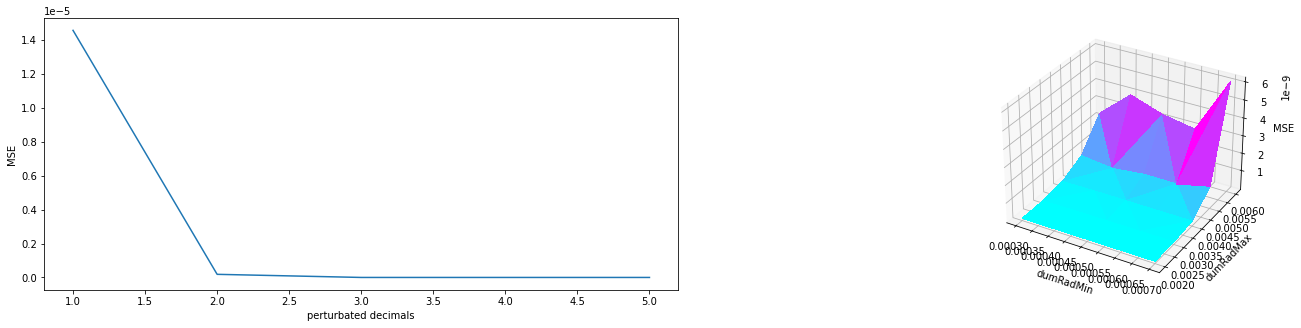

,dumRadMin,dumRadMax,pertDec,mse
129,0.0004,0.006,5.0,1.303932e-11
73,0.0006,0.005,4.0,1.471755e-11
63,0.0006,0.003,4.0,1.524855e-11
113,0.0004,0.003,4.0,1.524855e-11
53,0.0007,0.006,4.0,1.524855e-11
...,...,...,...,...
95,0.0005,0.005,1.0,5.738450e-05
65,0.0006,0.004,1.0,6.162092e-05
50,0.0007,0.006,1.0,6.469650e-05
30,0.0007,0.002,1.0,8.607943e-05


In [5]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [25, 5]

fig = plt.figure()

# First subplot
ax = fig.add_subplot(1, 2, 1)

pertOnly = df[(df['gpsPerturbated'] == True) & (df['dummyLocation'] == False)][['pertDec', 'mse']].sort_values('pertDec')
dummyOnly = df[(df['gpsPerturbated'] == False) & (df['dummyLocation'] == True)][['dumRadMin', 'dumRadMax', 'mse']].sort_values(['dumRadMin', 'dumRadMax'])

ax.plot(pertOnly['pertDec'], pertOnly['mse'])
ax.set_xlabel('perturbated decimals')
ax.set_ylabel('MSE')

# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_trisurf(
    dummyOnly['dumRadMin'],
    dummyOnly['dumRadMax'],
    dummyOnly['mse'],
    cmap=plt.get_cmap('cool'),
    edgecolor='grey',
    linewidth=0, antialiased=False)
ax.set_xlabel('dumRadMin')
ax.set_ylabel('dumRadMax')
ax.set_zlabel('MSE')
plt.show()

# pd.set_option("max_row", len(df[(df['gpsPerturbated'] == True) & (df['dummyLocation'] == True)]))
# pd.reset_option('max_row')
df[(df['gpsPerturbated'] == True) & (df['dummyLocation'] == True)][['dumRadMin','dumRadMax','pertDec','mse']].sort_values('mse')